# 3/5/20

In [31]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob

%matplotlib inline

sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.7)
plt.style.use('seaborn-whitegrid')

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

In [2]:
tree = uproot.open('/store17/petrov/data/kskl_sim/tr_ph_run004880.root')['tr_ph'] #old mc_v7

In [3]:
nevents = tree.pandas.df(branches=['simtype', 'simmom', 'simorig']).query('simtype==22&simorig==0')[['simmom']]

In [4]:
ebeam = tree.array('emeas').mean()
print('Энергия пучка:', ebeam, 'МэВ')

Энергия пучка: 550.0 МэВ


In [5]:
num_norads = len( tree.pandas.df(branches=['simtype', 'simmom', 'simorig']).query('simorig==0').\
      groupby('entry').agg({'simmom':'count'}).query('simmom==2') )
print('Кол-во событий без рад. фотонов: ', num_norads )

Кол-во событий без рад. фотонов:  3150


Выведу на экран максимальное количество фотонов в событии

In [6]:
print( 'Max photons in event: ', nevents.groupby('entry').agg({'simmom':'count'}).simmom.max() )

Max photons in event:  1


Всего событий: 20 000, посчитаю события с мягкими фотонами, с не слишком мягкими фотонами

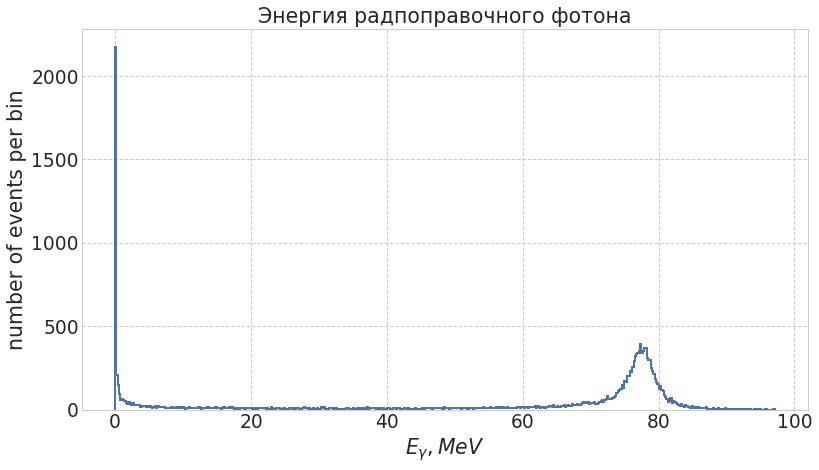

In [32]:
nevents.hist('simmom', bins=500, histtype='step', lw=2);
my_style('Энергия радпоправочного фотона', '$E_{\gamma}, MeV$', 'number of events per bin', '--')

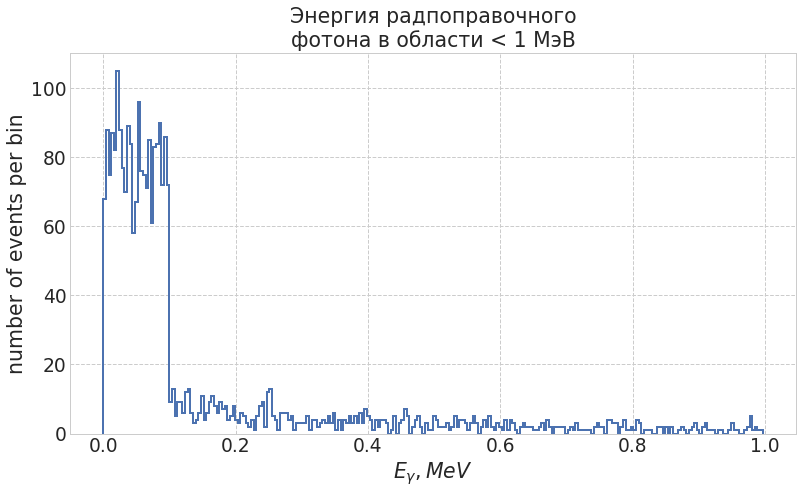

In [33]:
nevents.query('simmom<1').hist('simmom', bins=250, histtype='step', lw=2);
my_style('Энергия радпоправочного\nфотона в области < 1 МэВ', '$E_{\gamma}, MeV$', 'number of events per bin', '--')

In [34]:
very_soft_photons = 0.1 #MeV
soft_photons = 50 #MeV

In [44]:
sum_energy_per_event = nevents.groupby('entry').agg({'simmom': 'sum'})

num_soft = num_norads + len( sum_energy_per_event.query('simmom<@soft_photons') )
num_non_extremely_soft = len( sum_energy_per_event.query('simmom>@very_soft_photons'))
num_extremely_soft = num_norads + len( sum_energy_per_event.query('simmom<@very_soft_photons'))
num_soft_but_non_extremely = len( sum_energy_per_event.query('simmom>@very_soft_photons&simmom<@soft_photons') )
num_full = len(sum_energy_per_event) + num_norads

print('Кол-во событий с мягкими фотонами:', num_soft )
print('Кол-во событий с не очень мягкими фотонами:', num_non_extremely_soft )
print('Кол-во событий с очень мягкими фотонами:', num_extremely_soft )
print('Кол-во событий с мягкими, но не очень мягкими фотонами:', num_soft_but_non_extremely)
print('Полное число событий', len(sum_energy_per_event) + num_norads, '| должно быть 20000')
assert (len(sum_energy_per_event) + num_norads == 20000)

Кол-во событий с мягкими фотонами: 8151
Кол-во событий с не очень мягкими фотонами: 14860
Кол-во событий с очень мягкими фотонами: 5140
Кол-во событий с мягкими, но не очень мягкими фотонами: 3011
Полное число событий 20000 | должно быть 20000


In [45]:
num_soft/num_extremely_soft

1.5857976653696497

In [46]:
num_full/num_extremely_soft

3.8910505836575875

Теперь посчитаю радпоправку немного исправленной для моих нужд программой

In [37]:
print('E:', str(ebeam*2e-3) )

E: 1.1


In [3]:
%%bash
cd code
./a.out 1.5 50 10

Energy is 1.5, GeV
Reaction threshold is 0.9952, GeV
Cross Section File Name is cs_klks_cmd2
Successful reading... Cross section File contains 260 records

Radiative corrections calculation started..

Delta_dE: 0.0075 MeV
dE: 742.5 MeV
0.111573	0.280019	0.254365	0.2439	
Radiative correction at E = 1.5 GeV is equal to 3.77969
	Time of this calculation: 2 seconds

Radiative corrections calculation started..

Delta_dE: 0.0075 MeV
dE: 50 MeV
0.111573	0.0384251	0.0384484	0.0133645	
Radiative correction at E = 1.5 GeV is equal to 0.857196
	Time of this calculation: 2 seconds

Radiative corrections calculation started..

Delta_dE: 0.0075 MeV
dE: 10 MeV
0.111573	0.0313034	0.0313133	0.00884469	
Radiative correction at E = 1.5 GeV is equal to 0.777442
	Time of this calculation: 2 seconds


[IX - X chapters](https://arxiv.org/pdf/0901.2208.pdf)

In [22]:
import numpy as np

a = 1/137
p = np.pi
m = 2000
me = 0.511
G = 10

print( np.exp( 4*(-a/p)*np.log( m/me )*np.log( m/G ) ) )

0.6654203344674253


In [225]:
rad_all = 6.2538
rad_soft = 0.886078
rad_ext = 0.705577

In [237]:
print( f'         All rad: {rad_all*1e4/num_full:.2f}' )
print( f'         Sft rad: {rad_soft*1e4/num_soft:.2f}' )
print( f'Soft non ext rad: {(rad_soft - rad_ext)*1e4/num_soft_but_non_extremely:.2f}' )
print( f' All non ext rad: {(rad_all - rad_ext)*1e4/num_non_extremely_soft:.2f}' )

         All rad: 3.13
         Sft rad: 2.82
Soft non ext rad: 3.40
 All non ext rad: 3.19


$$\sigma_{born} = \frac{n}{L\varepsilon(1+\delta)} = \frac{n_0}{L\varepsilon_0}$$

1st case:

$$\sigma_{born} = \frac{n_{0} + n_{\gamma}}{L\varepsilon_{0}(1+\delta)} = \frac{n_{0} ( 1 + n_{\gamma}/n_{0} )}{L\varepsilon_{0}(1+\delta)} = \sigma_{born} \frac{( 1 + n_{\gamma}/n_{0} )}{(1+\delta)} $$

2nd case:

$$\sigma_{born} = \frac{n_{0} + n_{\gamma}}{L\varepsilon (1+\delta)} = \frac{n_{0} ( 1 + n_{\gamma}/n_{0} )}{L\varepsilon (1+\delta)}$$

$$ \varepsilon = \frac{ N_0 + N_{\gamma} }{ N_0^{tot} + N_{\gamma}^{tot}  } = \frac{ N_0 }{ N_0^{tot} } \frac{(1+N_{\gamma}/N_0)}{(1+N_{\gamma}^{tot}/N_0^{tot})} = \varepsilon_0 \frac{ 1+N_{\gamma}/N_0 }{ 1+N_{\gamma}^{tot}/N_0^{tot} } $$

then

$$\sigma_{born} =  \frac{ ( 1 + n_{\gamma}/n_{0} ) ( 1+N_{\gamma}^{tot}/N_0^{tot} ) }{ (1+\delta) (1+N_{\gamma}/N_0) } \frac{n_{0}}{L \varepsilon_0}$$

In [184]:
it = uproot.pandas.iterate(path='/store17/petrov/data/kskl_sim/tr_ph_run*.root',
                           #path='/store17/petrov/data/kskl_sim_custom/tr_ph/*.root',
                           treepath='tr_ph', branches=['simtype', 'simmom', 'simorig', 'emeas'])

In [155]:
df = pd.concat([i for i in it])

In [156]:
df

simtype      simmom  simorig       emeas
entry  subentry                                          
0      0             130  262.161835        0  562.500000
       1             310  262.161835        0  562.500000
       2             211  229.234131      310  562.500000
       3            -211  258.836395      310  562.500000
1      0             130  257.726776        0  562.500000
...                  ...         ...      ...         ...
779999 0             130  104.753098        0  508.600006
       1             310  104.765755        0  508.600006
       2             211  176.441879      310  508.600006
       3            -211  246.824600      310  508.600006
       4              22    0.043295        0  508.600006

[4756825 rows x 4 columns]

In [157]:
df = df.query('simtype==22&simorig==0')[['simmom', 'emeas']].copy()

In [158]:
df.groupby('entry').agg({'simmom':'count'}).max()

simmom    1
dtype: int64

In [159]:
df = df.reset_index(level=1, drop=True)

In [160]:
counted_df = df.groupby('emeas').agg({'simmom':'count'})

In [182]:
extr_soft_ph_cut = 3 #MeV
max_ph_cut = None #MeV

counted_df = counted_df.rename({'simmom':'with_photon'}, axis=1)
counted_df['all_events'] = 20000
counted_df['no_photon'] = counted_df['all_events'] - counted_df['with_photon']
counted_df['extremely_soft'] = df.query('simmom<@extr_soft_ph_cut').groupby('emeas').agg({'simmom':'count'})['simmom'] \
                                                                                + counted_df['no_photon']
counted_df['all_photons'] =  df.query('simmom<@max_ph_cut').groupby('emeas').agg({'simmom':'count'})['simmom'] \
                            + counted_df['no_photon'] if max_ph_cut else counted_df['all_events']
counted_df['energy_err'] = extr_soft_ph_cut
counted_df['rad_corr'] = counted_df['all_photons']/counted_df['extremely_soft']
counted_df['rad_corr_err'] =  np.sqrt( 1/counted_df['all_photons'] + 1/counted_df['extremely_soft'] )*\
                                                                       counted_df['rad_corr']

In [183]:
counted_df.head()

,with_photon,all_events,no_photon,extremely_soft,all_photons,energy_err,rad_corr,rad_corr_err
emeas,,,,,,,,
508.600006,8158,20000,11842,19855,20000,3,1.007303,0.010091
550.000000,16850,20000,3150,6238,20000,3,3.206156,0.046496
562.500000,17197,20000,2803,5476,20000,3,3.652301,0.055704
575.000000,17612,20000,2388,4778,20000,3,4.185852,0.067403
587.500000,17821,20000,2179,4385,20000,3,4.561003,0.076054


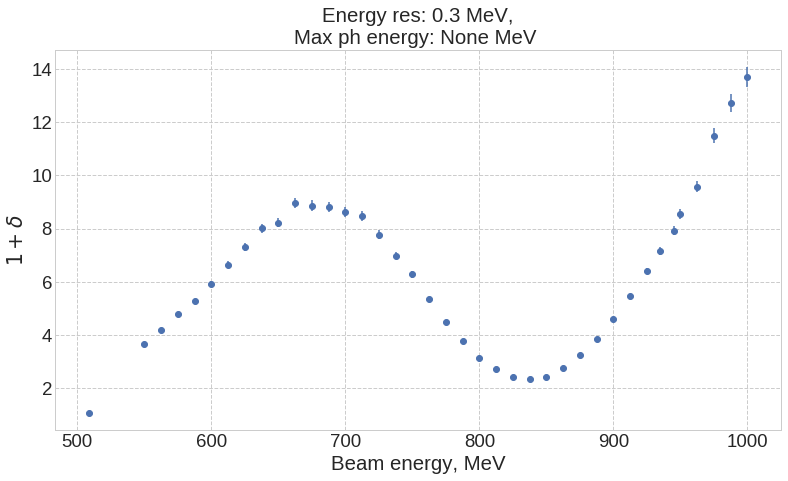

In [169]:
plt.errorbar(counted_df.index, counted_df.rad_corr, xerr=counted_df.energy_err, yerr=counted_df.rad_corr_err, fmt='o')
my_style(f'Energy res: {extr_soft_ph_cut} MeV,\nMax ph energy: {max_ph_cut} MeV ', 
         'Beam energy, MeV', '$1+\delta$', '--')